<a href="https://colab.research.google.com/github/bye23mj/suanLee/blob/main/_9_1_XGBoost%2C_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost

* 트리 기반의 앙상블 기법
* 분류에 있어서 다른 알고리즘보다 좋은 예측 성능을 보여줌
* XGBoost는 GBM 기반이지만, GBM의 단점인 느린 수행 시간과 과적합 규제 부재 등의 문제를 해결
* 병렬 CPU 환경에서 빠르게 학습 가능

## xgboost

**- Booster Parameters ( 모델의 조건 설정 )**
* n_estimators [default = 100] : 나무의 개수 (=num_boost_round [default = 10] : 파이썬 래퍼에서 적용)
* early_stopping_rounds 
        최대한 몇 개의 트리를 완성해볼 것인지 
        valid loss에 더이상 진전이 없으면 멈춤
        과적합을 방지할 수 있음, n_estimators 가 높을때 주로 사용.

* learning_rate [default = 0.1] (=eta [default = 0.3] : 파이썬 래퍼에서 적용)
        학습 단계별로 가중치를 얼만큼 사용할지 결정/ 이전의 결과를 얼마나 반영할건지
        낮은 eta -> 낮은 가중치 -> 다음 단계의 결과물 적게 반영 -> 보수적
        일반적으로 0.01 ~ 0.2
        높은 값으로 다른 파라미터 조절하여 결정한 후, 낮춰서 최적의 파라미 결정
        gradient boost에서는 기울기의 의미, 작으면 꼼꼼히 내려가고 크면 급하게 내려감
* min_child_weight [default = 1]
        child 에서 필요한 모든 관측치에 대한 가중치의 최소 합
        이 값보다 샘플 수가 작으면 leaf node가 되는 것
        너무 크면 under-fitting 될 수 있음
        CV로 조절해야함
* max_depth [default = 6]
        트리의 최대 깊이
        일반적으로 3 ~ 10  
        CV로 조절해야함
* gamma [default = 0]
        트리에서 추가적으로 가지를 나눌지를 결정할 최소 손실 감소 값
        값이 클수록 과적합 감소 효과
* subsample [default = 1] (=sub_sample : 파이썬 래퍼에서 적용)
        각 트리마다 데이터 샘플링 비율
        over-fitting 방지
        일반적으로 0.5 ~ 1
* colsample_bytree [default = 1]
        각 트리마다 feature 샘플링 비율
        일반적으로 0.5 ~ 1
* reg_lambda [default = 1] (=lambda : 파이썬 래퍼에서 적용)
        L2 regularization(ex. 릿지) 가중치
        클수록 보수적
* reg_alpha [default = 0] (=alpha : 파이썬 래퍼에서 적용)
        L1 regularization(ex. 라쏘) 가중치
        클수록 보수적
        특성이 매우 많은때 사용해볼만 함
* scale_pos_weight [default = 1]
        데이터가 불균형할때 사용, 0보다 큰 값
        보통 값을 음성 데이터 수/ 양성 데이터 수 값으로 함

**- Learning Task Parameters ( 모델의 목표 및 계산 방법 설정 )**
* objective [default = reg:linear] (목적 함수)
        binary:logistic :이진 분류를 위한 로지스틱 회귀, 클래스가 아닌 예측된 확률 반환
        multi:softmax : softmax를 사용한 다중 클래스 분류, 확률이 아닌 예측된 클래스 반환
        multi:softprob : softmax와 같지만 각 클래스에 대한 예상 확률 반환
* eval_metric [목적 함수에 따라 디폴트 값이 다름(회귀-rmse / 분류-error)]
        rmse : root mean square error
        mae : mean absolute error
        logloss : negative log-likelihood
        error : binary classificaion error rate (임계값 0.5)
        merror : multiclass classification error rate
        mlogloss : multiclass logloss
        auc : area under the curve
* seed [default = 0]
        시드값 고정 (나중에 재현할때 같은 값을 출력하기 위해)
 

In [ ]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.datasets import load_boston, load_diabetes
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree

import graphviz
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

## 파이썬 기반 XGBoost

In [ ]:
cancer = load_breast_cancer()
X_trina, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=123)
dtrain = xgb.DMatrix(data=X_trina, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {'max_depth' : 3, 'eta' : 0.1, 'objective' : 'binary:logistic', 'eval_metric' : 'logloss', 'early_stopping' : 100}
num_rounds = 400

In [ ]:
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=evals)

[0]	train-logloss:0.609436	eval-logloss:0.610101
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540471	eval-logloss:0.540739
[2]	train-logloss:0.482113	eval-logloss:0.484899
[3]	train-logloss:0.433653	eval-logloss:0.43922
[4]	train-logloss:0.39072	eval-logloss:0.39791
[5]	train-logloss:0.353717	eval-logloss:0.362107
[6]	train-logloss:0.322225	eval-logloss:0.329962
[7]	train-logloss:0.292921	eval-logloss:0.301791
[8]	train-logloss:0.267306	eval-logloss:0.278011
[9]	train-logloss:0.244087	eval-logloss:0.25775
[10]	train-logloss:0.22517	eval-logloss:0.240372
[11]	train-logloss:0.208073	eval-logloss:0.222709
[12]	train-logloss:0.191772	eval-logloss:0.207948
[13]	train-logloss:0.17746	eval-logloss:0.195312
[14]	train-logloss:0.164082	eval-logloss:0.184597
[15]	train-logloss:0.152497	eval-logloss:0.171834
[16]	train-logloss:0.141981	eval-logloss:0.161516
[17]	train-loglo

In [ ]:
import numpy as np

predicts = xgb_model.predict(dtest)
print(np.round(predicts[:10], 3))

[1.    0.999 0.001 0.995 0.001 0.989 0.995 0.998 0.966 0.795]


In [ ]:
preds = [1 if x > 0.5 else 0 for x in predicts]
print(preds[:10])

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


In [ ]:
print("정확도:{}".format(accuracy_score(y_test,preds)))
print("정밀도:{}".format(precision_score(y_test,preds)))
print("재현율:{}".format(recall_score(y_test,preds)))

정확도:0.9736842105263158
정밀도:0.972972972972973
재현율:0.9863013698630136


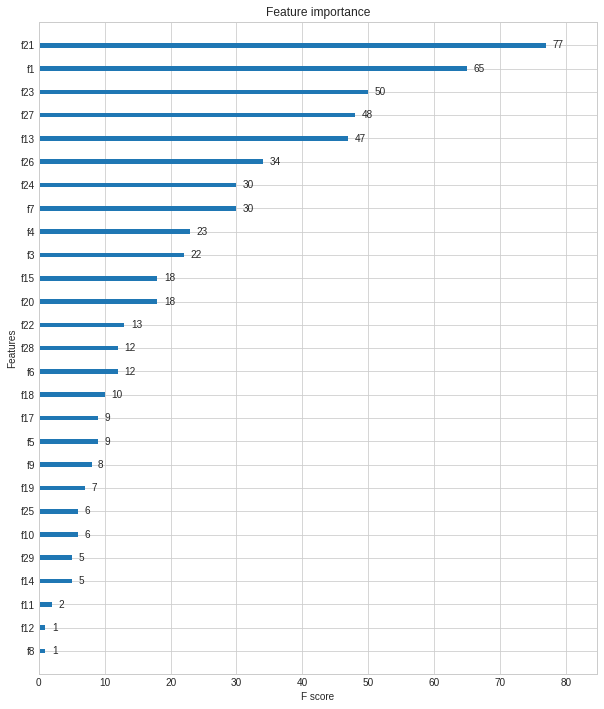

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

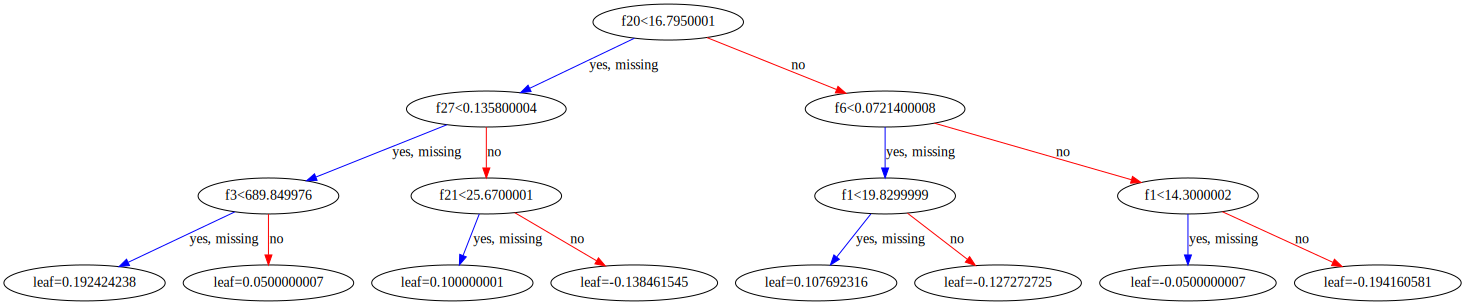

In [ ]:
dot_data = xgb.to_graphviz(xgb_model)
graph = graphviz.Source(dot_data)
graph

## XGBClassifier

### 붓꽃 데이터

In [ ]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.2, random_state=123)

In [ ]:
xgbc = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:, 1]

In [ ]:
cross_val = cross_validate(estimator=xgbc, X=iris.data, y=iris.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test time : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.08897647857666016 (+/- 0.004354102950551734)
avg score time : 0.0013285636901855468 (+/- 0.00012037627269918074)
avg test time : 0.96 (+/- 0.024944382578492935)


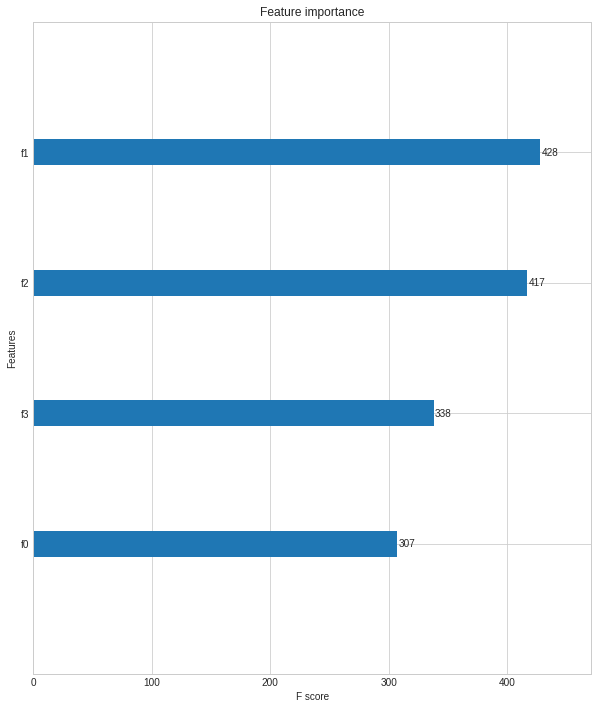

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbc, ax=ax)

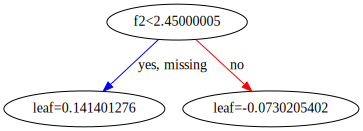

In [ ]:
dot_data = xgb.to_graphviz(xgbc)
graph = graphviz.Source(dot_data)
graph

### 와인 데이터

In [ ]:
iris = load_wine()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.2, random_state=123)

In [ ]:
xgbc = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:, 1]

In [ ]:
cross_val = cross_validate(estimator=xgbc, X=iris.data, y=iris.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.15368809700012206 (+/- 0.00766181034829973)
avg score time : 0.0014578819274902344 (+/- 6.505523444023955e-05)
avg test score : 0.9609523809523809 (+/- 0.028267341226138717)


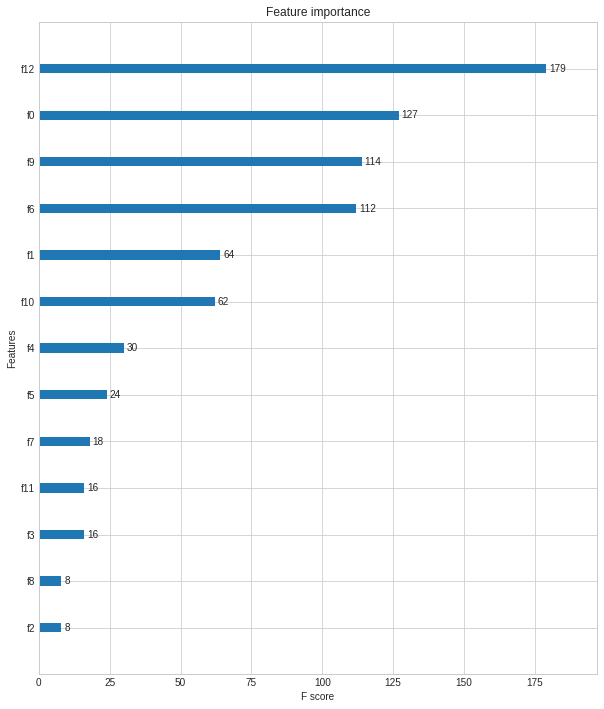

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbc, ax=ax)

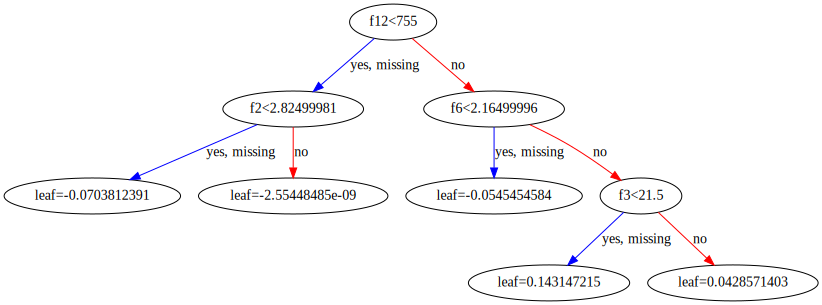

In [ ]:
dot_data = xgb.to_graphviz(xgbc)
graph = graphviz.Source(dot_data)
graph

### 유방암 데이터

In [ ]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state=123)

In [ ]:
xgbc = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:, 1]

In [ ]:
cross_val = cross_validate(estimator=xgbc, X=iris.data, y=iris.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.08205127716064453 (+/- 0.002760292950367827)
avg score time : 0.0008600234985351562 (+/- 2.0403059083100433e-05)
avg test score : 0.9609523809523809 (+/- 0.028267341226138717)


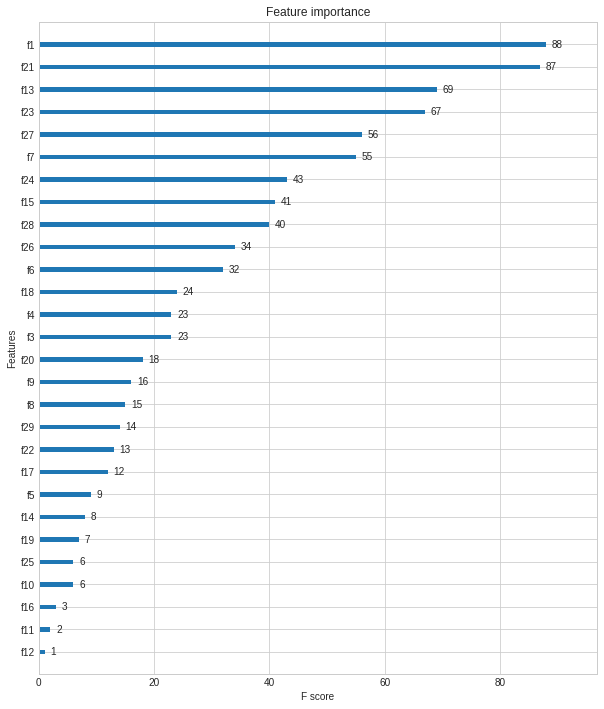

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbc, ax=ax)

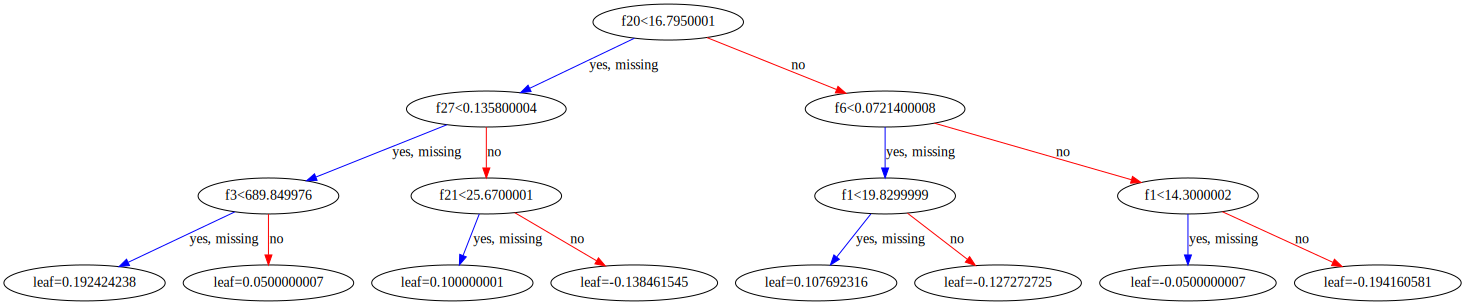

In [ ]:
dot_data = xgb.to_graphviz(xgbc)
graph = graphviz.Source(dot_data)
graph

## XGBRegressor

### 보스턴 데이터

In [ ]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size = 0.2, random_state=123)

In [ ]:
xgbr = XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=3, objective='reg:squarederror')
xgbr.fit(X_train, y_train)
preds = xgbr.predict(X_test)

In [ ]:
cross_val = cross_validate(estimator=xgbr, X=boston.data, y=boston.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.2812089443206787 (+/- 0.030974031247771813)
avg score time : 0.0031226158142089845 (+/- 0.0009975224947712696)
avg test score : 0.6884390572208088 (+/- 0.16499747484510102)


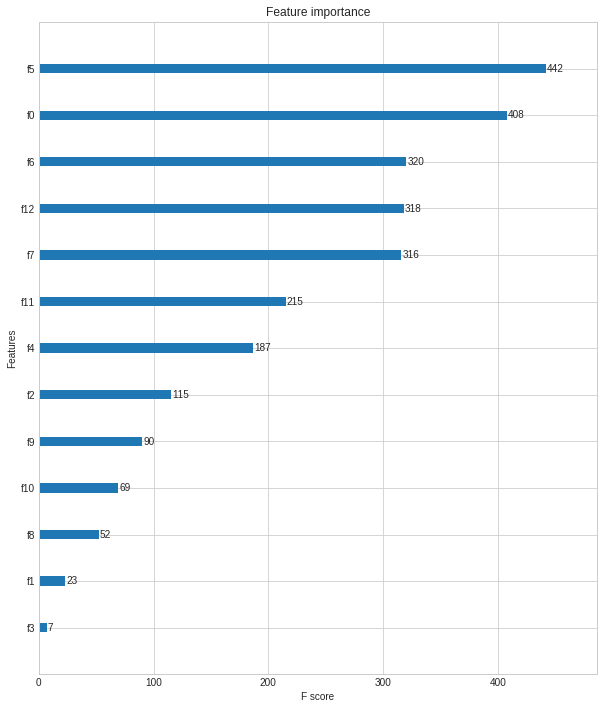

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbr, ax=ax)

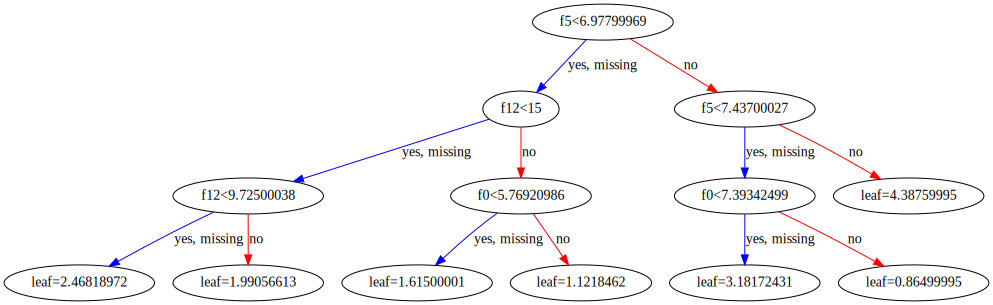

In [ ]:
dot_data = xgb.to_graphviz(xgbr)
graph = graphviz.Source(dot_data)
graph

### 당뇨병 데이터

In [ ]:
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size = 0.2, random_state=123)

In [ ]:
xgbr = XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=3, objective='reg:squarederror')
xgbr.fit(X_train, y_train)
preds = xgbr.predict(X_test)

In [ ]:
cross_val = cross_validate(estimator=xgbr, X=diabetes.data, y=diabetes.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.2908176898956299 (+/- 0.024826404128509158)
avg score time : 0.005919790267944336 (+/- 0.003056177007752986)
avg test score : 0.3000529025802777 (+/- 0.07589311710543882)


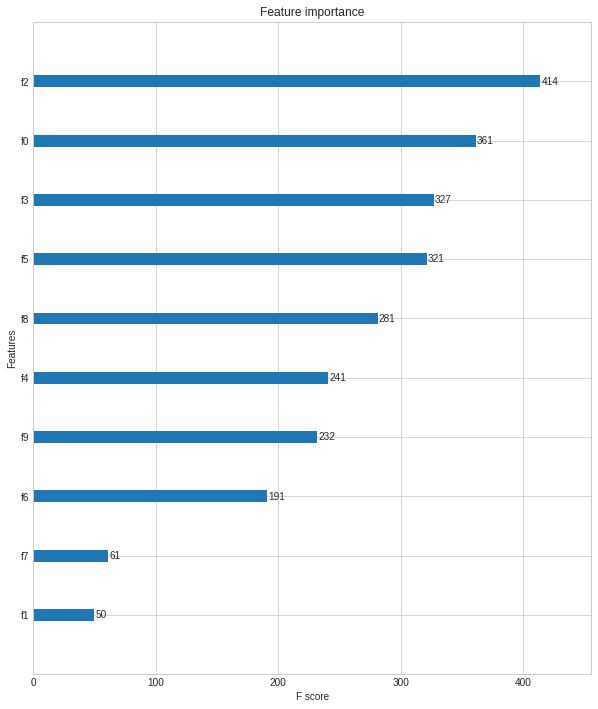

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbr, ax=ax)

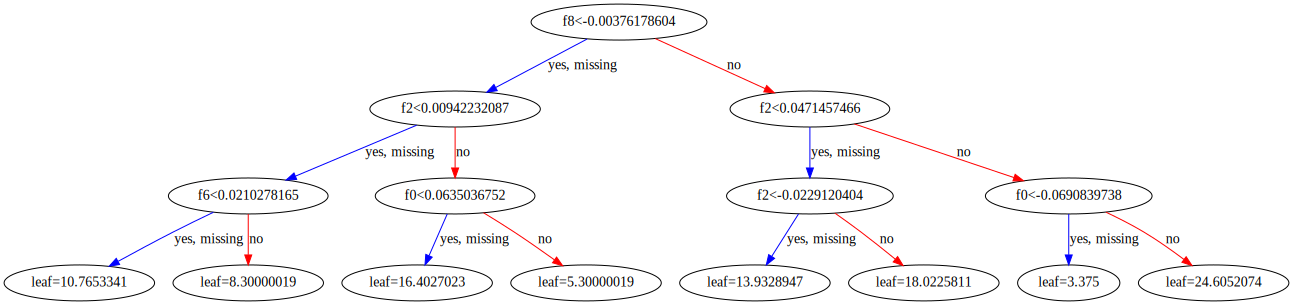

In [ ]:
dot_data = xgb.to_graphviz(xgbr)
graph = graphviz.Source(dot_data)
graph

# LightGBM

* 빠른 학습과 예측 시간
* 더 적은 메모리 사용
* 범주형 특징의 자동 변환과 최적 분할

In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree

## LGBMClassifier

### 붓꽃 데이터

In [ ]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.2, random_state=123)

In [ ]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals)
preds = lgbmc.predict(X_test)

In [ ]:
cross_val = cross_validate(estimator=lgbmc, X=iris.data, y=iris.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.05514669418334961 (+/- 0.004821952127430508)
avg score time : 0.0012351512908935548 (+/- 6.977442632446632e-05)
avg test score : 0.9533333333333335 (+/- 0.06182412330330468)


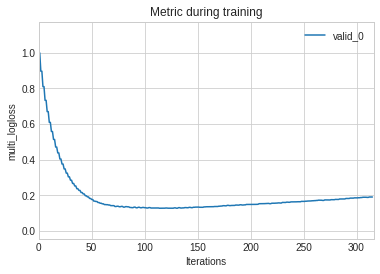

In [ ]:
plot_metric(lgbmc)

[('petal width (cm)', 187), ('petal length (cm)', 186), ('sepal width (cm)', 149), ('sepal length (cm)', 70)]


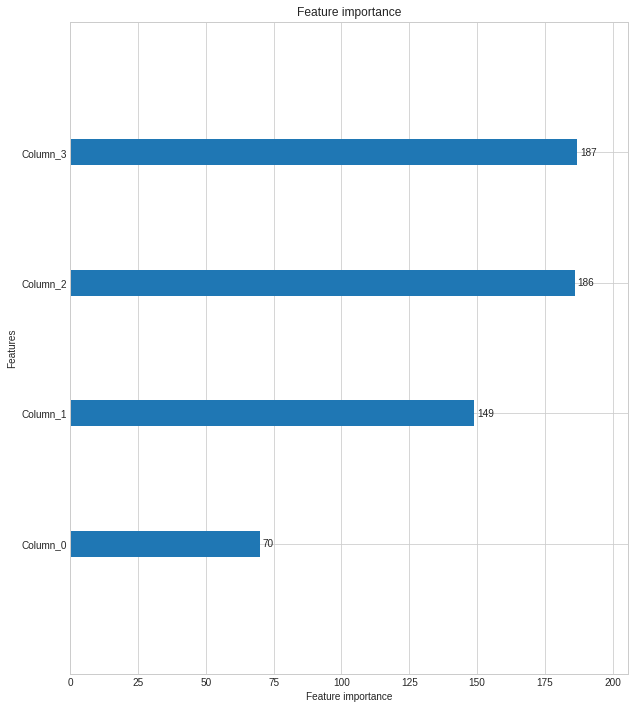

In [ ]:
import operator
d = dict()
for i in range(len(iris.feature_names)):
  #print(cancer.feature_names[i], lgbmc.feature_importances_[i])
  d[iris.feature_names[i]] = lgbmc.feature_importances_[i]

linking = sorted(d.items(), key=operator.itemgetter(1), reverse  = True)
print(linking[:5])

plot_importance(lgbmc, figsize=(10,12))

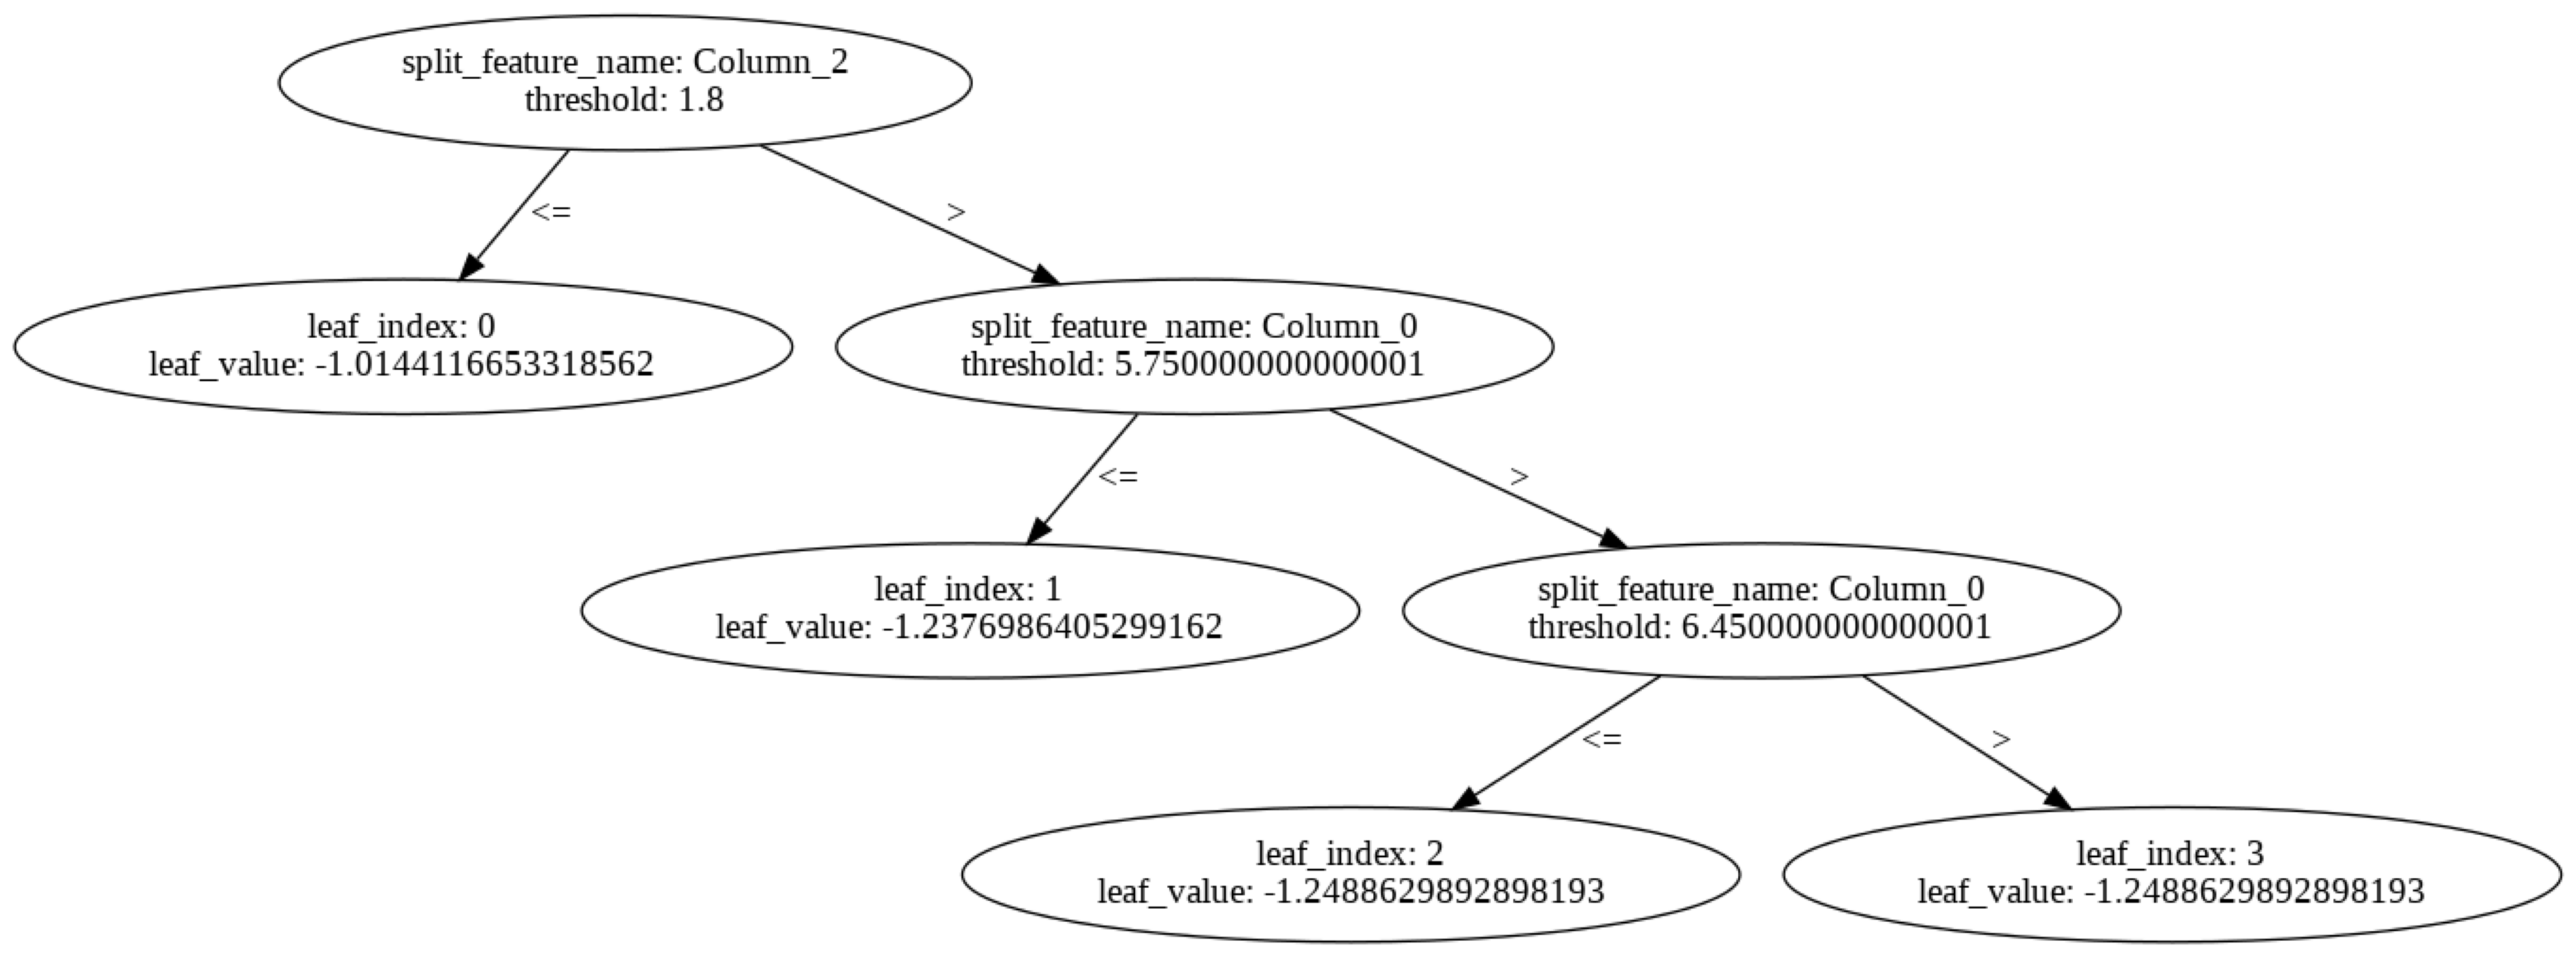

In [ ]:
plot_tree(lgbmc, figsize=(128,24))

### 와인 데이터

In [ ]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size = 0.2, random_state=123)

In [ ]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals)
preds = lgbmc.predict(X_test)

In [ ]:
cross_val = cross_validate(estimator=lgbmc, X=wine.data, y=wine.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.0677685260772705 (+/- 0.006235599137504783)
avg score time : 0.0012639999389648438 (+/- 0.00010232669884014493)
avg test score : 0.9720634920634922 (+/- 0.030430686929136006)


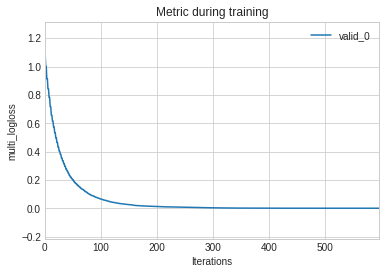

In [ ]:
plot_metric(lgbmc)

[('color_intensity', 327), ('proline', 326), ('flavanoids', 315), ('alcohol', 307), ('malic_acid', 298)]


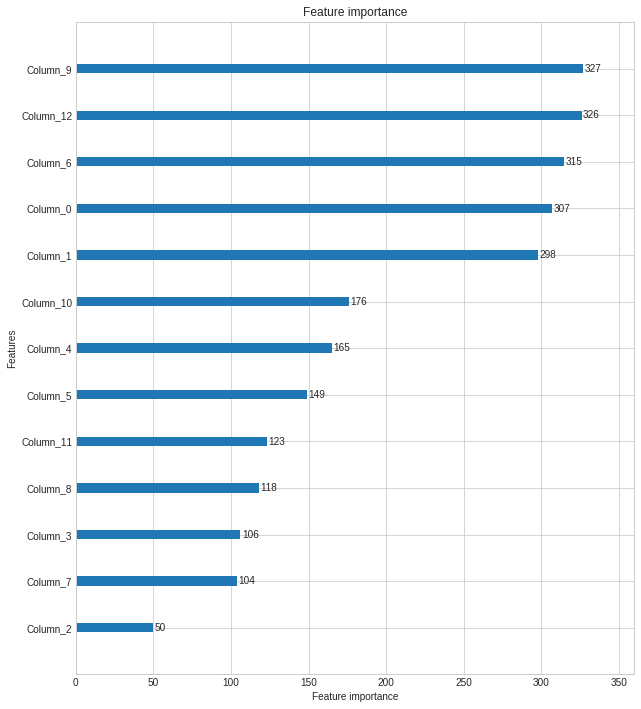

In [ ]:
d = dict()
for i in range(len(wine.feature_names)):
  #print(cancer.feature_names[i], lgbmc.feature_importances_[i])
  d[wine.feature_names[i]] = lgbmc.feature_importances_[i]

linking = sorted(d.items(), key=operator.itemgetter(1), reverse  = True)
print(linking[:5])

plot_importance(lgbmc, figsize=(10,12))

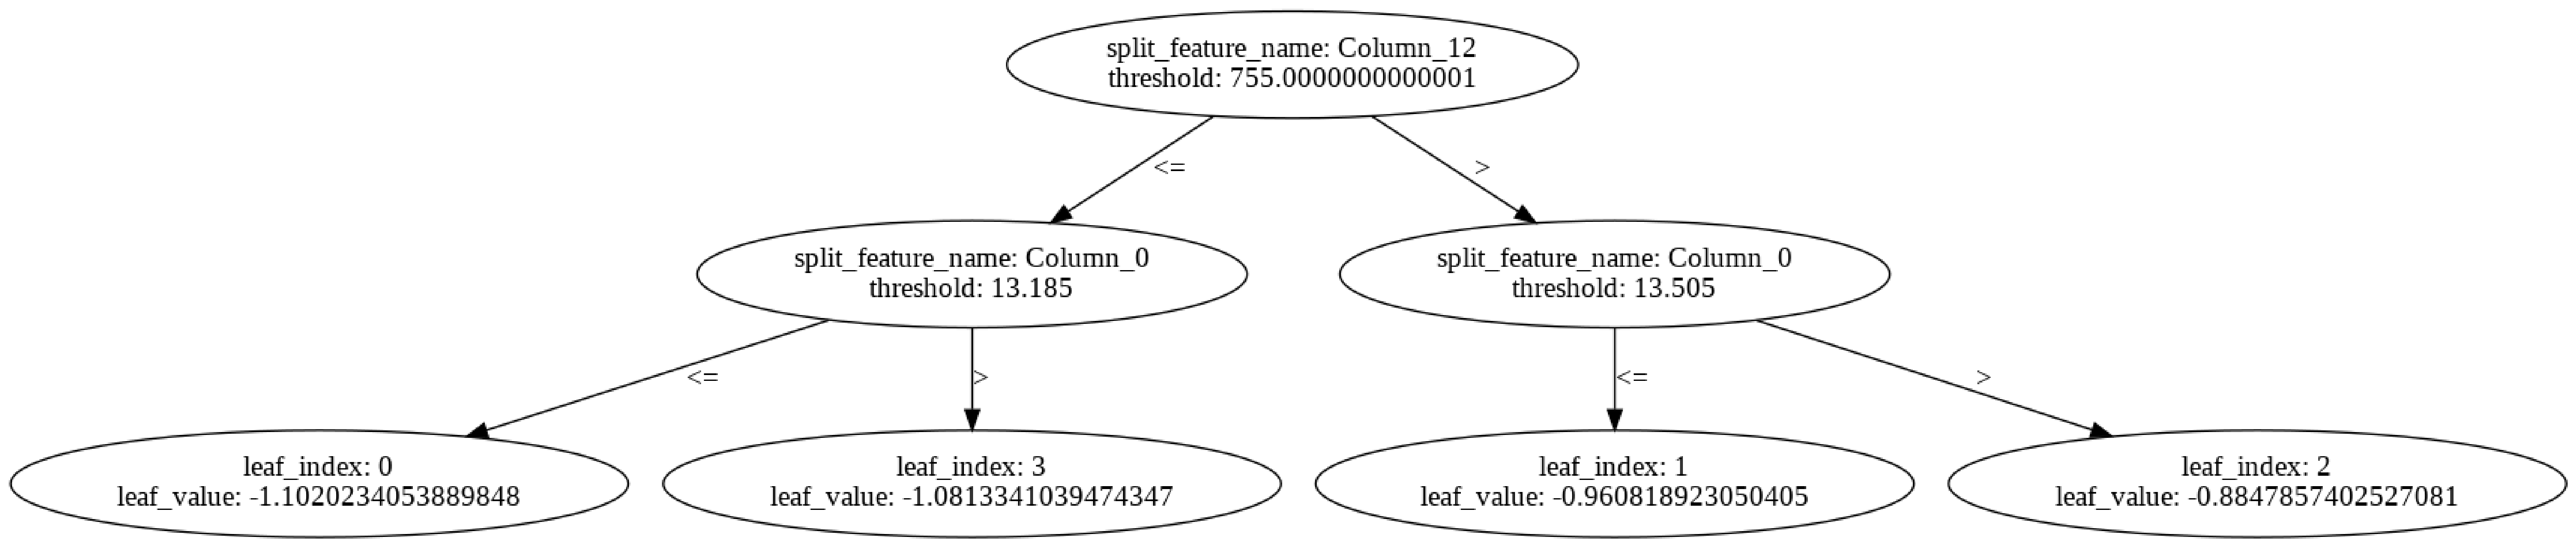

In [ ]:
plot_tree(lgbmc, figsize=(128,24))

### 유방암 데이터

In [ ]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state=123)

In [ ]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals)
preds = lgbmc.predict(X_test)

In [ ]:
cross_val = cross_validate(estimator=lgbmc, X=cancer.data, y=cancer.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.21073250770568847 (+/- 0.003041126977514547)
avg score time : 0.002477550506591797 (+/- 0.00021026305214088986)
avg test score : 0.9701288619779536 (+/- 0.0180536992368202)


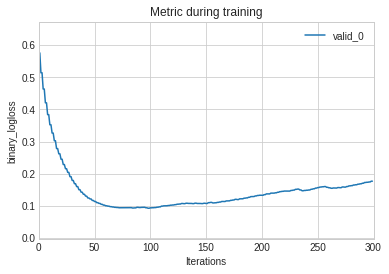

In [ ]:
plot_metric(lgbmc)

[('worst texture', 104), ('mean texture', 64), ('mean concave points', 49), ('worst perimeter', 48), ('area error', 46)]


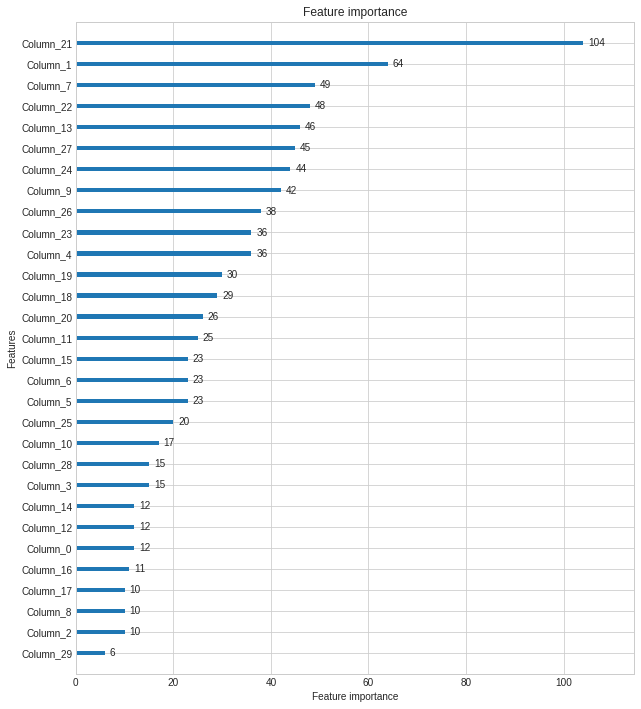

In [ ]:
import operator


def linking(feature_names, feature_importances):
  d = dict()

  for i in range(len(feature_names)):
    d[feature_names[i]] = feature_importances[i]

  linking = sorted(d.items(), key=operator.itemgetter(1), reverse  = True)
  print(linking[:5])

linking(cancer.feature_names, lgbmc.feature_importances_)

plot_importance(lgbmc, figsize=(10,12))

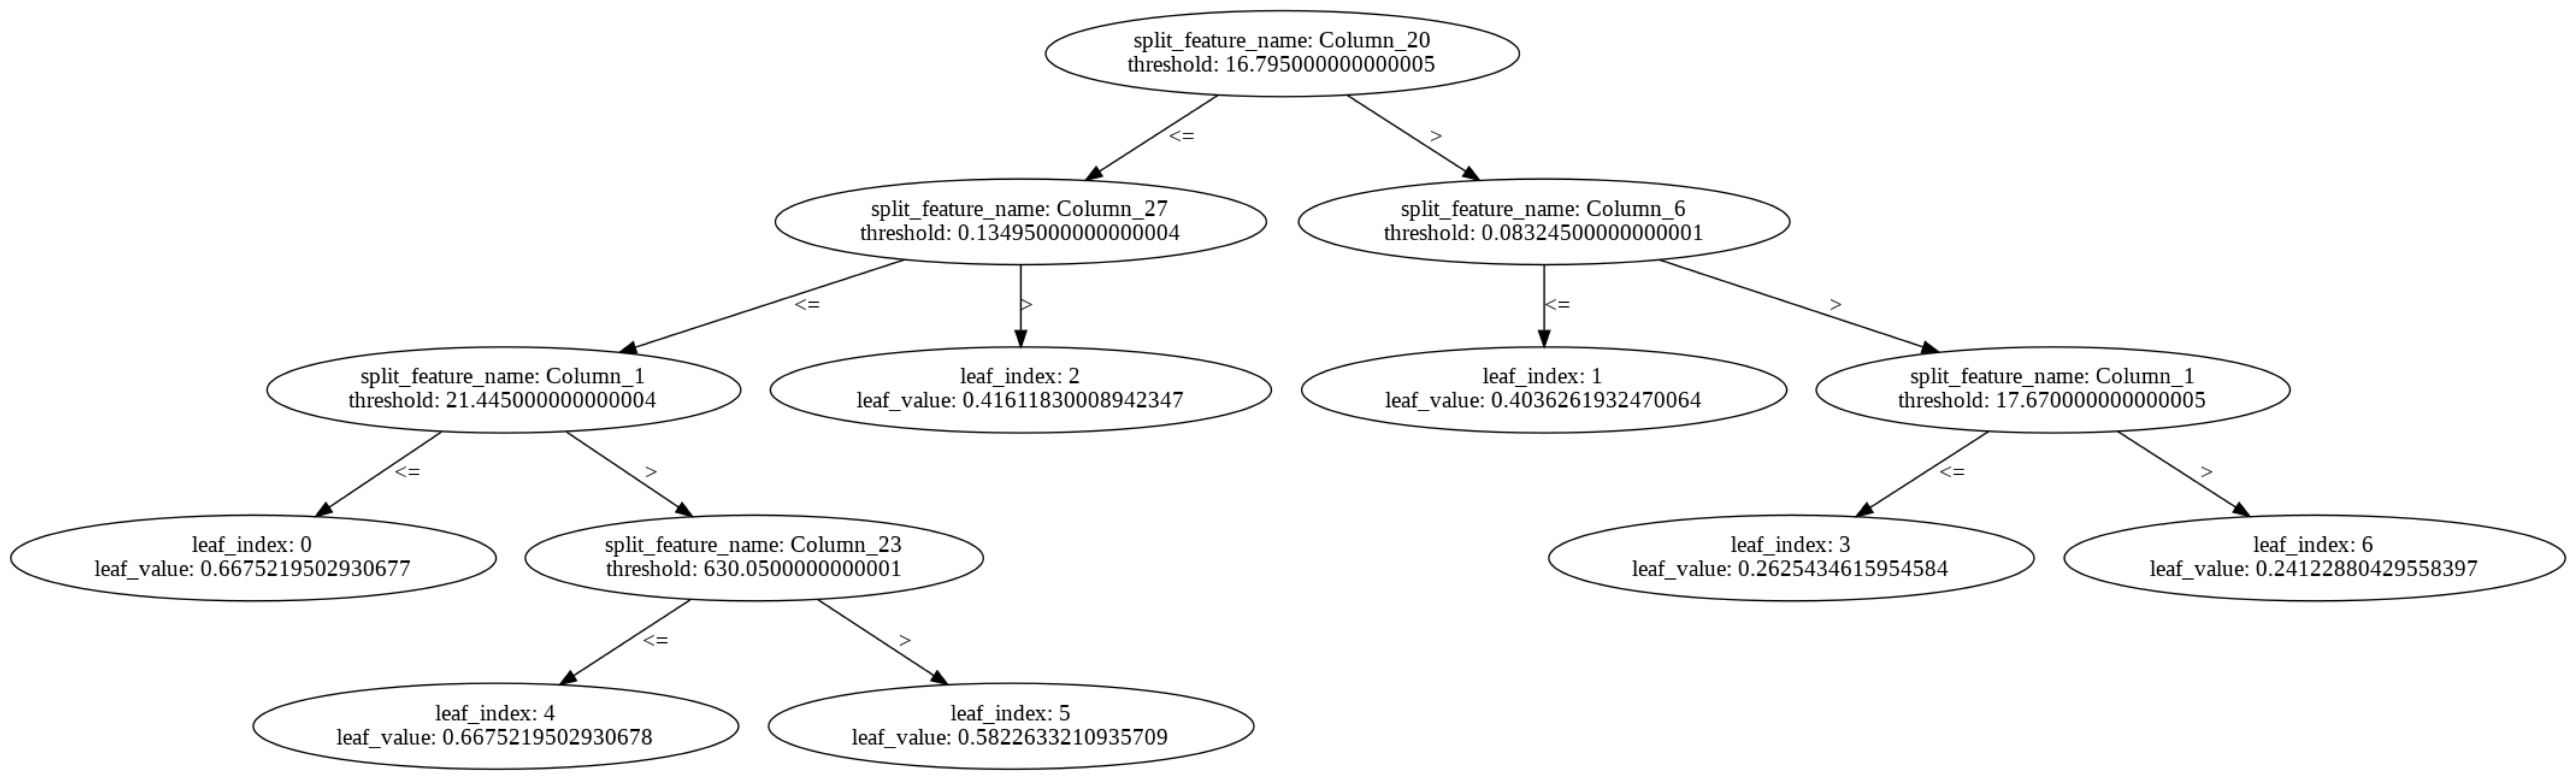

In [ ]:
plot_tree(lgbmc, figsize=(128,24))

## LGBMRegressor

### 보스턴 데이터

In [ ]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size = 0.2, random_state=123)

In [ ]:
lgbmr = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbmr.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals)
preds = lgbmr.predict(X_test)

In [ ]:
cross_val = cross_validate(estimator=lgbmr, X=boston.data, y=boston.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.27983789443969725 (+/- 0.0246085616535928)
avg score time : 0.004414033889770508 (+/- 0.0008813253813123708)
avg test score : 0.5692468252571979 (+/- 0.2956636613238221)


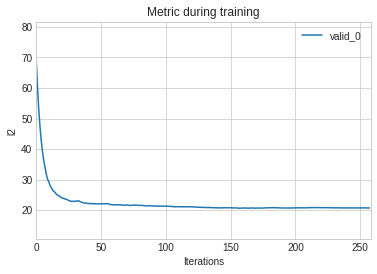

In [ ]:
plot_metric(lgbmr)

[('LSTAT', 373), ('AGE', 359), ('DIS', 325), ('RM', 309), ('CRIM', 263)]


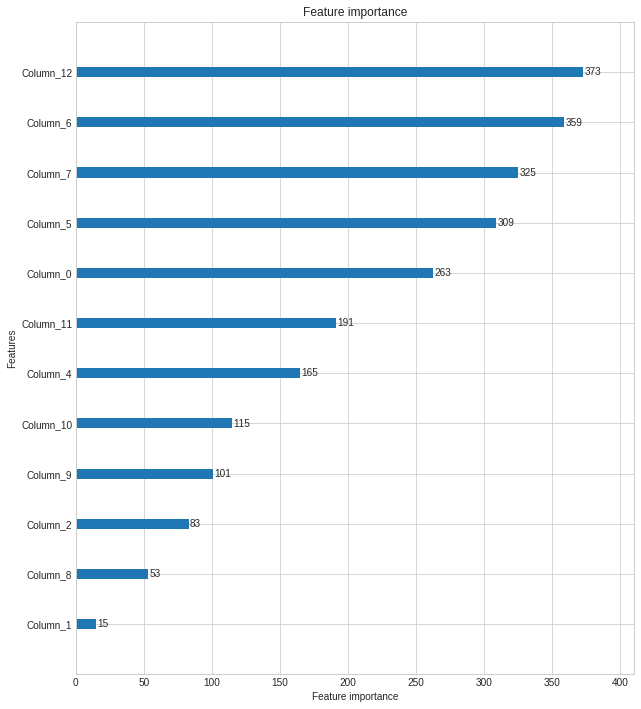

In [ ]:
linking(boston.feature_names, lgbmr.feature_importances_)

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbmr, ax=ax)

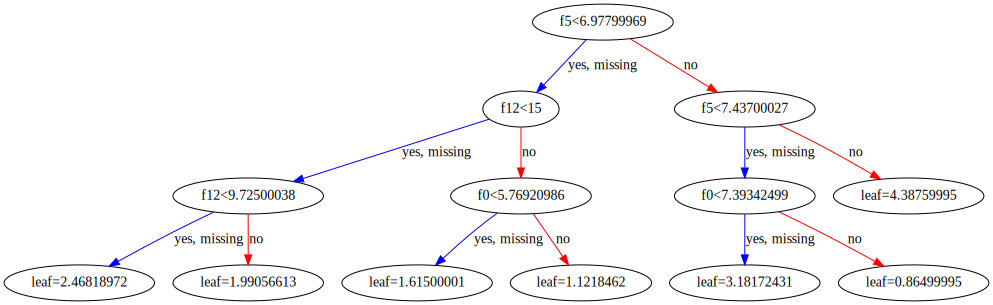

In [ ]:
dot_data = xgb.to_graphviz(xgbr)
graph = graphviz.Source(dot_data)
graph

### 당뇨병 데이터

In [ ]:
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size = 0.2, random_state=123)

In [ ]:
lgbmr = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbmr.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals)
preds = lgbmr.predict(X_test)

In [ ]:
cross_val = cross_validate(estimator=lgbmr, X=diabetes.data, y=diabetes.target,cv=5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time : {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.11171026229858398 (+/- 0.004766356808828382)
avg score time : 0.0031165599822998045 (+/- 0.00012574941745373809)
avg test score : 0.30867643947179507 (+/- 0.07010708786960605)


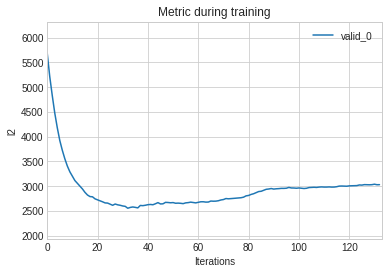

In [ ]:
plot_metric(lgbmr)

[('bmi', 81), ('s5', 58), ('bp', 57), ('age', 41), ('s6', 40)]


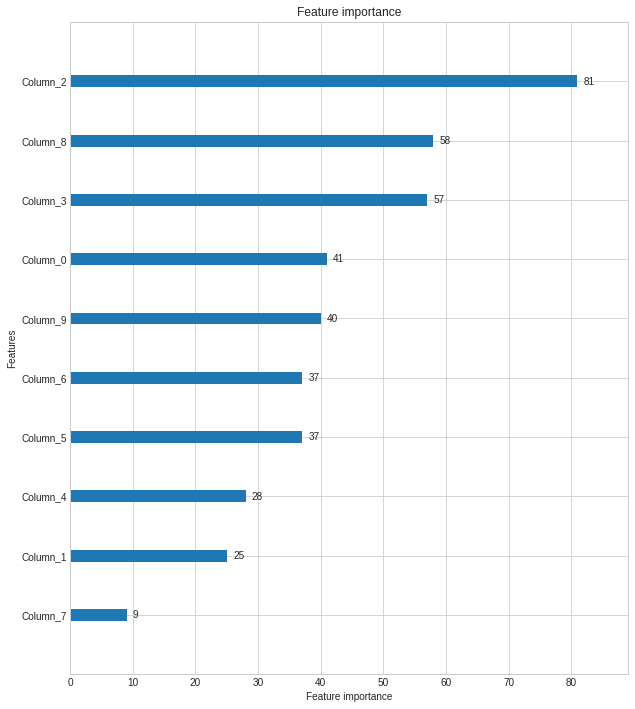

In [ ]:
linking(diabetes.feature_names, lgbmr.feature_importances_)

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbmr, ax=ax)

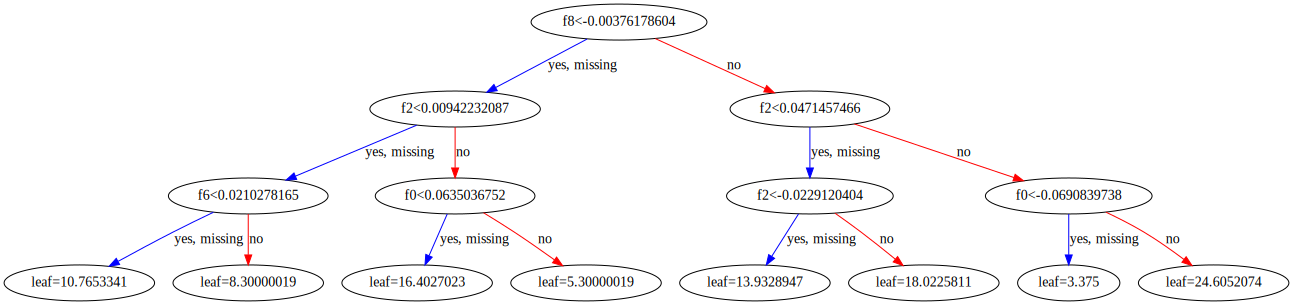

In [ ]:
dot_data = xgb.to_graphviz(xgbr)
graph = graphviz.Source(dot_data)
graph